# Branch and Bound

Branch and Bound is an algorithm design paradigm for discrete and combinatorial optimization problems. It is used to solve problems where the solution space is large and cannot be exhaustively searched. The algorithm works by dividing the problem into smaller subproblems (branching) and calculating an upper and lower bound for the objective function in these subproblems. If the lower bound of a subproblem is greater than the upper bound of another, the subproblem can be discarded (pruning). This process continues until the optimal solution is found. Branch and Bound is commonly used in solving problems like the Traveling Salesman Problem, Knapsack Problem, and Integer Programming.

## An illustrative example

To illustrate the Branch and Bound algorithm, let's consider a small example with 3 variables:

1. **Objective Function**: Maximize $ z = 3x_1 + 2x_2 + x_3 $
2. **Constraints**:
    - $ x_1 + x_2 + x_3 \leq 4 $
    - $ 2x_1 + x_2 \leq 3 $   
    - $ x_1, x_2, x_3 \geq 0 $
    - $ x_1, x_2, x_3 $ are integers

We start by solving the linear relaxation of the problem (ignoring the integer constraints) and then use the Branch and Bound method to find the optimal integer solution.

## Setting the Environment

In [11]:
%pip install matplotlib pandas numpy pulp networkx

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pulp as pl
import networkx as nx

# Define the problem
prob = pl.LpProblem("Maximize_Z", pl.LpMaximize)

# Define the variables
x1 = pl.LpVariable('x1', lowBound=0, cat='Integer')
x2 = pl.LpVariable('x2', lowBound=0, cat='Integer')
x3 = pl.LpVariable('x3', lowBound=0, cat='Integer')

# Define the objective function
prob += 3*x1 + 2*x2 + x3, "Objective"

# Define the constraints
prob += x1 + x2 + x3 <= 4, "Constraint 1"
prob += 2*x1 + x2 <= 3, "Constraint 2"

# Solve the problem
prob.solve()

# Print the results
print(f"Status: {pl.LpStatus[prob.status]}")
print(f"x1 = {pl.value(x1)}")
print(f"x2 = {pl.value(x2)}")
print(f"x3 = {pl.value(x3)}")
print(f"Objective = {pl.value(prob.objective)}")

Note: you may need to restart the kernel to use updated packages.
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/vincent/GitHub/Course-Materials/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ea0aceff202f46e89c460c5cc0b32dc9-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/ea0aceff202f46e89c460c5cc0b32dc9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 22 RHS
At line 25 BOUNDS
At line 29 ENDATA
Problem MODEL has 2 rows, 3 columns and 5 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7 - 0.00 seconds
Cgl0004I processed model has 2 rows, 3 columns (3 integer (1 of which binary)) and 5 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -7
Cbc0038I Cleaned solution of -7
Cbc0038

## Branch and Bound Algorithm

### Setting the Environment

In [21]:
# Linear relaxation
x1.cat = 'Continuous'
x2.cat = 'Continuous'
x3.cat = 'Continuous'


# Define a class to store node information
class Node:
    def __init__(self, name, parent, prob):
        self.name = name
        self.new_constraints = 'None'
        self.parent = parent
        self.prob = prob
        self.solution = dict()
        self.status = 'pending'
        
# The Best Node so far
BestNode = None 

# Define the node list
node_list = []

# Define a function to solve the node, update the status, and return the node
def solve_node(node):
    global BestNode
    node.prob.solve()
    
    print(f"Node: {node.name}")
    print(f"Status: {pl.LpStatus[node.prob.status]}")
    print(f"Objective = {node.prob.objective.value()}")
    for var in node.prob.variables():
        print(f"{var.name} = {var.varValue}")
    
    
    lpstatus = pl.LpStatus[node.prob.status]
    
    if lpstatus == 'Optimal':
        for var in node.prob.variables():
            node.solution[var.name] = var.varValue
        if(BestNode != None and node.prob.objective.value() <= BestNode.prob.objective.value()):
            node.status = 'pruned'
        else:
            # We check if all the variables are integer
            all_int = True
            for var in node.prob.variables():
                if var.varValue != int(var.varValue):
                    all_int = False
                    break
            if all_int:
                if BestNode == None or node.prob.objective.value() > BestNode.prob.objective.value():
                    BestNode = node
                node.status = 'integer'
            else:
                node.status = 'fractional'  
    elif lpstatus == 'Infeasible':
        node.status = 'infeasible'
    else:
        node.status = 'unknown'
    
    return node.status

# Define a function to create a child nodes
def create_child_nodes(parent_node):
    child_nodes = []
    
    if parent_node.status == 'integer' or parent_node.status == 'infeasible' or parent_node.status == 'pruned':
        return child_nodes
    
    # Select the variable to branch on
    max_fractionality = 0
    branch_var = None
    for var in parent_node.prob.variables():
        if var.varValue != int(var.varValue):
            fractionality = var.varValue - int(var.varValue)
            if fractionality > max_fractionality:
                max_fractionality = fractionality
                branch_var = var
    
    # Create the child nodes
    for i in range(2):
        child_prob = parent_node.prob.copy()
        child_name = parent_node.name + f".{i}"
        if(parent_node.name == 'Root'):
            child_name = f"Node.{i}"
        cut = None
        if i == 1:
            cut = branch_var <= int(branch_var.varValue)
        else:
            cut = branch_var >= int(branch_var.varValue) + 1
        child_prob += cut
        child_node = Node(child_name, parent_node, child_prob)
        child_node.new_constraints = cut.__str__()
        child_nodes.append(child_node)
    return child_nodes
    
   
# Define a function to create and plot the branch and bound tree
def plot_tree(node_list):
    G = nx.DiGraph()
    for node in node_list:
        label = f"{node.name}"
        if node.new_constraints != 'None':
            label += f"\n{node.new_constraints}"
        for name, value in node.solution.items():
            label += f"\n{name}={value:.2f}"
        label += f"\n{node.status}"
        G.add_node(node.name, label=label)
        if node.parent != None:
            G.add_edge(node.parent.name, node.name)
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, labels=labels)
    nx.draw_networkx_nodes(G, pos, node_shape='s', node_size=5000, node_color='lightblue')
    plt.show()
    
    
def plot_tree2(node_list):
    G = nx.DiGraph()

    # Create nodes with labels
    for node in node_list:
        label = f"{node.name}"
        
        if hasattr(node, 'new_constraints') and node.new_constraints != 'None':
            label += f"\n{node.new_constraints}"
        
        if hasattr(node, 'solution') and isinstance(node.solution, dict):
            for name, value in node.solution.items():
                label += f"\n{name}={value:.2f}"

        if hasattr(node, 'status'):
            label += f"\n{node.status}"

        G.add_node(node.name, label=label)

        if hasattr(node, 'parent') and node.parent is not None:
            G.add_edge(node.parent.name, node.name)

    # Use a tree-like layout if possible
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Requires pygraphviz
    except:
        pos = nx.spring_layout(G)  # Fallback

    labels = nx.get_node_attributes(G, 'label')

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, font_size=10, node_size=4000, node_color="lightblue", edge_color="gray")
    plt.show()

## The Root Node

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/vincent/GitHub/Course-Materials/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f76eca974dd54b9abd8a6766dc9357c4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/f76eca974dd54b9abd8a6766dc9357c4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 16 RHS
At line 19 BOUNDS
At line 20 ENDATA
Problem MODEL has 2 rows, 3 columns and 5 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (0) rows, 3 (0) columns and 5 (0) elements
0  Obj -0 Dual inf 5.9999997 (3)
0  Obj -0 Dual inf 5.9999997 (3)
2  Obj 7
Optimal - objective value 7
Optimal objective 7 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Node: Root
Status: Optimal
Objective = 7.0
x1 = 1.5

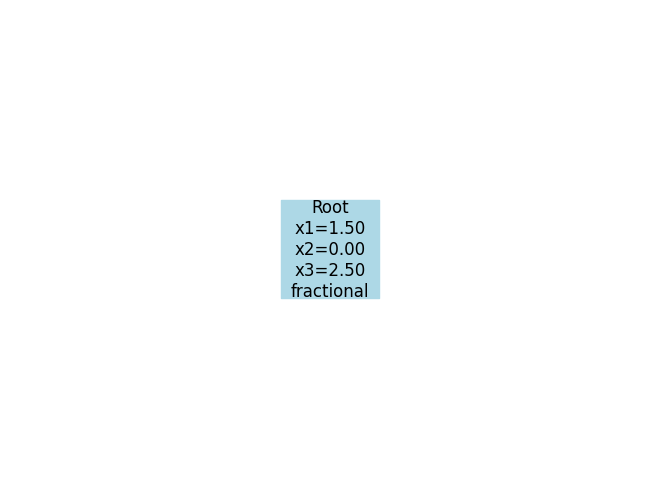

In [22]:
RootNode = Node("Root", None, prob)
solve_node(RootNode)
node_list.append(RootNode)

plot_tree(node_list)

## The Two First Childs

Maximize_Z:
MAXIMIZE
3*x1 + 2*x2 + 1*x3 + 0
SUBJECT TO
Constraint_1: x1 + x2 + x3 <= 4

Constraint_2: 2 x1 + x2 <= 3

_C1: x1 >= 2

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/vincent/GitHub/Course-Materials/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/dbe769fac13442dcb05bfa26a3bc889f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/dbe769fac13442dcb05bfa26a3bc889f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 18 RHS
At line 22 BOUNDS
At line 23 ENDATA
Problem MODEL has 3 rows, 3 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj -0 Primal inf 1.9999999 (1) Dual inf 5.9999997 (3)
0  Obj -0 Pr

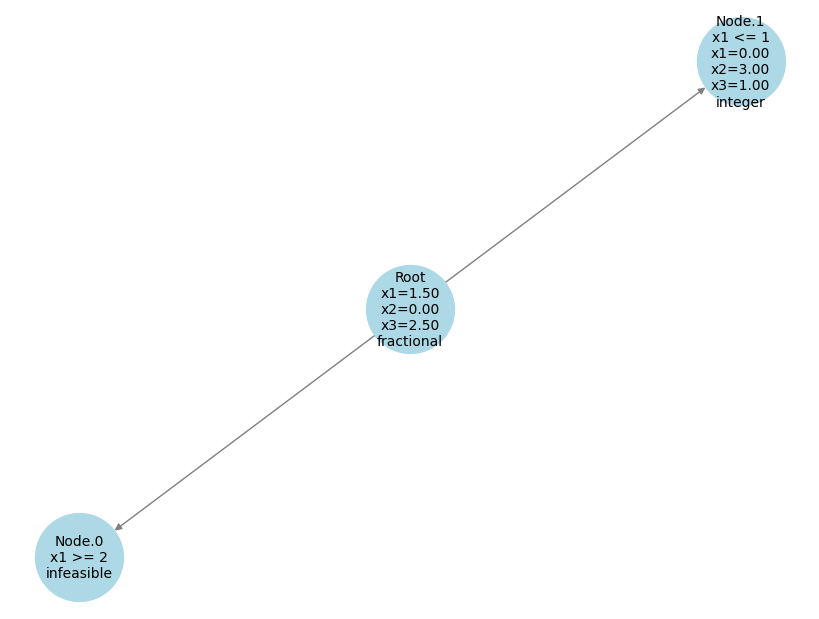

In [23]:
childs = create_child_nodes(RootNode)

for child in childs:
    print(child.prob)   
    solve_node(child)
    node_list.append(child)
    
plot_tree2(node_list)
